# Simulating communities of *E. coli* with the dFBA+ODE framework

This Jupyter notebook illustrates how to use the framework provided [here](https://github.com/QTB-HHU/dfba-ode-framework_ecoli-diauxie) to simulate a community of *E. coli* subpopulations growing on different carbon sources.

For more details please refer to the [main publication (preprint)](https://www.biorxiv.org/content/early/2018/04/26/291492) and to the [software metapaper (in preparation)](NA).

## The ecDiauxie macro

The framework provides an Object Oriented infrastructure to interface communities of metabolic network models with ordinary differential equations. All the variables in the ecDiauxie.py macro can be set via command line. In this notebook we will focus on the construction of the model and will only use the relevant parts of the code. 

### Load modules
   

In [16]:
import sys
sys.path.append('code/python/') 
import classModel as cmo
import classReaction as cre
import classMetabolite as cme
import classConsortium as cco
import classPlotter as plotter
import classConvertionFactors as ccf
import cobra
import pandas
from cobra.flux_analysis import parsimonious
import numpy as np
import matplotlib.pyplot as plt
import argparse
import plstyles
import random
import cPickle
import json
import copy
from matplotlib import gridspec

### Variables setting

These are the values used for the simulation of Figure 4.

In [17]:
expcondLabels = {'batch_high_Ac': 'grown on 45 mM Ac',
                 'batch_low_Ac': 'grown on 4 mM Ac',
                 'batch_mixed_Ac': 'grown on 15 mM Glc, 32 mM Ac',
                 'batch_low_Glc': 'grown on 15 mM Glc',
                 'fedbatch_low_Ac': 'grown on 15 mM Glc, fed 4 mM Ac',
                 'fedbatch_high_Ac': 'grown on 15 mM Glc, fed 32 mM Ac'}

outpath='outputs/notebook/'
label='diauxic_shift'
ename = 'ecoli core'

# GSM model, default = E. coli core
# http://bigg.ucsd.edu/models/e_coli_core
mpath = 'ecoli/bigg/e_coli_core.xml'
bmf = 'BIOMASS_Ecoli_core_w_GAM'
rxnnames = {'EX_glc_e':'EX_glc__D_e', 
            'EX_o2_e': 'EX_o2_e',
            'EX_ac_e':'EX_ac_e'}

ODtoGDW=0.33
volExt = 0.03
volUn = 'L'

maxtime = 10.5
biomass0 = 0.0038


#biomass dilution rate in chemostat, 1/hr
ch = 0. 

death_rate = -0.03

thrPc = 0.99999
pcECgl = 0.95
strratioecgl = ("%.2f" % pcECgl).replace('.','p')
if pcECgl > thrPc:
    pcECgl = thrPc
if pcECgl < (1 - thrPc):
    pcECgl = 1 - thrPc

### Set the Carbon initial conditions

Either do custom settings or set one of the experimental conditions to True.

In [18]:
expcond = 'batch_low_Glc'
glucose0 = 15.0 #mM
acetate0 = 0.0 #mM
fb=0.
afb=0.
ac_thr = 0.0
t_glc = 0.0

runhighacetate = runlowacetate = runbatchglc = runmixedacetate = runfedlowacetate = runfedhighacetate = runvarmabatch = runvarmafedbatch =False
runfedlowacetate = True

if runhighacetate:
    print('Simulating Batch Growth on 45mM Acetate as in Enjalbert2015')
    expcond = 'batch_high_Ac'
    glucose0 = 0.0
    acetate0 = 45.0
elif runlowacetate:
    print('Simulating Batch Growth on 4mM Acetate as in Enjalbert2015')
    expcond = 'batch_low_Ac'
    glucose0 = 0.0
    acetate0 = 4.0
elif runbatchglc:
    print('Simulating Batch Growth on 15mM Glucose as in Enjalbert2015')
    expcond = 'batch_low_Glc'
    glucose0 = 15.0 #mM
    acetate0 = 0.0 #mM
    fb=0.
    afb=0.
elif runmixedacetate:
    print('Simulating Batch Growth on 15mM Glucose 32mM Acetate as in Enjalbert2015')
    expcond = 'batch_mixed_Ac'
    glucose0 = 15.0
    acetate0 = 32.0
elif runfedlowacetate:
    print('Simulating Batch Growth on 15mM Glucose and constant 4mM Acetate as in Enjalbert2015')
    expcond = 'fedbatch_low_Ac'
    glucose0 = 15.0
    acetate0 = 0.0
    afb=1.0
    ac_thr = 4.0
    t_glc = 4.0
elif runfedhighacetate:
    print('Simulating Batch Growth on 15mM Glucose and constant 32mM Acetate as in Enjalbert2015')
    expcond = 'fedbatch_high_Ac'
    glucose0 = 15.0
    acetate0 = 32.0
    afb=1.0
    ac_thr = 32.0
    t_glc = 4.0
elif runvarmabatch:
    print('Simulating Batch Growth on Glucose as in Varma1994 Fig.7')
    expcond = 'varma_batch'
    glucose0 = 10.8
    acetate0 = 0.4
elif runvarmafedbatch:
    print('Simulating Fed Batch Growth on Glucose as in Varma1994 Fig.10')
    expcond = 'varma_fedbatch'
    glucose0 = 0.82
    acetate0 = 0.1
    #glucose is continuously provided
    #0.2 g/(L*hr)
    #1 g = 5.5 mmol
    #dGLC/dt = ... + fb ==> units = mmol/hr
    fb = 5.5*0.2*volExt #mmol/hr
else:
    print('Simulating custom conditions')

exitname = '%s-%s-%s' % (ename.replace(' ','_'), expcond, label) 

## biomass0 is already gDW
## glucose0 and acetate0 are concentrations (mM)
## dMetabolites are initialized with quantities (mmol)
acetate0 = volExt*acetate0 # mM*L = mmol
glucose0 = volExt*glucose0 # mM*L = mmol

Simulating Batch Growth on 15mM Glucose and constant 4mM Acetate as in Enjalbert2015


### Transition functions parameters

Comment/uncomment the parameters based on how you want to implement the transitions.

In [19]:

transition_efficiency = 0.9

# No transition
#psi0 = 0.
#psi_transition_rate = 0.
#psi_transition_KM = 0.
#phi0 = 0.
#phi_transition_rate = 0.
#phi_transition_KM = 0.

# Noise transition
#psi0 = 0.04
#phi0 = 0.04
#psi_transition_rate = 0.
#psi_transition_KM = 0.
#phi_transition_rate = 0.
#phi_transition_KM = 0.

# Concentration dependent transition
psi0 = 0.04
phi0 = 0.04
psi_transition_rate = 0.2
phi_transition_rate = 0.2
psi_transition_KM = 30.0
phi_transition_KM = 5.0


### Set the flux constraints

These values are either taken from literature or calibrated on the data from Varma and Palsson 1994.

In [20]:
## Uptake parameters
## Uptake Vmax 10 mmol/g/hr (Gosset, 2005)
## Uptake Km 10 muM = 0.01 mM (Gosset, 2005)
vmaxexglc = 10. #mmol/g/hr
vmaxexace = 10. #mmol/g/hr
kmuptake = 0.01 #mM
## Parametrized with Varma 1994
vminoxygen = 11.5
ubexace = 3.0

## Build the two *E. coli* models

Define two DModels. 

In [21]:
## DMetabolite and DReaction instances for 
## ECgl 
## i.e. the Glucose consuming population

biomass_ECgl = cme.Biomass([biomass0*pcECgl], {'growth': [(1, 'biomass_ECgl')], 'dilution': [(ch, None)], 'death': [(death_rate, 'biomass_ECgl')],
                                               'psi_transition': [(-1., 'biomass_ECgl')], 'phi_transition': [(transition_efficiency, 'biomass_ECac')]})
ex_glucose_ECgl = cme.DMetabolite('glc_D_e', [glucose0], False, {'glucose_exchange': [(1, 'biomass_ECgl')], 'glucose_fed': [(fb, None)] })
ex_acetate_ECgl = cme.DMetabolite('ac_e', [acetate0], False, {'acetate_exchange': [(1, 'biomass_ECgl')]})#, 'acetate_fed': [(afb, None)]})
    
oxygen_exchange_ECgl = cre.DReaction(rxnnames['EX_o2_e'], cre.FixedBound(vminoxygen, 0), False)
### Ac secretion but no uptake
acetate_exchange_ECgl = cre.DReaction(rxnnames['EX_ac_e'], cre.FixedBound(0., ubexace), True)

glucose_exchange_ECgl = cre.DReaction(rxnnames['EX_glc_e'], cre.MichaelisMenten1(ex_glucose_ECgl, 1, vmaxexglc, kmuptake, 1, upperBound=15.), False)
growth_ECgl = cre.DReaction(bmf, cre.FixedBound(0., 1000.))

## DMetabolite and DReaction instances for 
## ECac 
## i.e. the Acetate consuming population

biomass_ECac = cme.Biomass([biomass0*(1-pcECgl)], {'growth': [(1, 'biomass_ECac')], 'dilution': [(ch, None)], 'death': [(death_rate, 'biomass_ECac')],
                                                   'psi_transition': [(transition_efficiency, 'biomass_ECgl')], 'phi_transition': [(-1., 'biomass_ECac')]})
ex_glucose_ECac = cme.DMetabolite('glc_D_e', [glucose0], False, {'glucose_exchange': [(1, 'biomass_ECac')] })
ex_acetate_ECac = cme.DMetabolite('ac_e', [acetate0], False, {'acetate_exchange': [(1, 'biomass_ECac')], 'acetate_fed': [(afb, 'biomass_ECac')]})
    
oxygen_exchange_ECac = cre.DReaction(rxnnames['EX_o2_e'], cre.FixedBound(vminoxygen, 0), False)
acetate_exchange_ECac = cre.DReaction(rxnnames['EX_ac_e'], cre.MichaelisMenten1(ex_acetate_ECac, 1, vmaxexace, kmuptake, 1, upperBound=ubexace), False)
### EX_glc off
glucose_exchange_ECac = cre.DReaction(rxnnames['EX_glc_e'], cre.FixedBound(0.,0.), False)
growth_ECac = cre.DReaction(bmf, cre.FixedBound(0., 1000.))

acetate_fed_ECac = cre.DReaction(None, cre.SquareWave(9.1, 20, 1, t_glc), True, isODE=True)


### Transition functions

Define the dynamics of transitions

In [22]:
lrxn = None
lrxn2 = None


hctrans = 5

## phi = Glc -> Ac ##
## ECglc senses Ac and transitions
biomass_psi_transition_ECgl = cre.DReaction(None, cre.MichaelisMentenLinked(ex_acetate_ECgl, lowerBound=0.,
                                                                            maxVelocity=psi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=psi_transition_KM, linkedReaction=lrxn, onThr=0., offset=psi0), True, isODE=True)
# Need a copy to avoid duplicate entries; TODO: add option for class model to not update object dMetabolite/dReaction
#biomass_psi_transition_ECac = copy.copy(biomass_psi_transition_ECgl)
biomass_psi_transition_ECac = cre.DReaction(None, cre.MichaelisMentenLinked(ex_acetate_ECgl, lowerBound=0.,
                                                                            maxVelocity=psi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=psi_transition_KM, linkedReaction=lrxn, onThr=0., offset=psi0), True, isODE=True)

## phi = Ac -> Glc ##
## ECac senses Glc and transitions
biomass_phi_transition_ECac = cre.DReaction(None, cre.MichaelisMentenLinked(ex_glucose_ECac, lowerBound=0.,
                                                                            maxVelocity=phi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=phi_transition_KM, linkedReaction=lrxn2, onThr=0., offset=phi0), True, isODE=True)
# Need a copy to avoid duplicate entries; TODO: add option for class model to not update object dMetabolite/dReaction
#biomass_phi_transition_ECgl = copy.copy(biomass_phi_transition_ECac)
biomass_phi_transition_ECgl = cre.DReaction(None, cre.MichaelisMentenLinked(ex_glucose_ECac, lowerBound=0.,
                                                                            maxVelocity=phi_transition_rate, hillCoeff=hctrans,
                                                                            mmConstant=phi_transition_KM, linkedReaction=lrxn2, onThr=0., offset=phi0), True, isODE=True)

### Initialize the DModel objects

In [23]:
dyRxn_ECgl = {'glucose_exchange': glucose_exchange_ECgl, 
              'oxygen_exchange': oxygen_exchange_ECgl,
              #'acetate_fed': acetate_fed_ECgl,
              'acetate_exchange': acetate_exchange_ECgl,
              'psi_transition': biomass_psi_transition_ECgl,
              'phi_transition': biomass_phi_transition_ECgl,
              'growth': growth_ECgl}
dyMet_ECgl = {'biomass_ECgl': biomass_ECgl,
              'ex_glucose': ex_glucose_ECgl,
              'ex_acetate': ex_acetate_ECgl}

model_ECgl = cmo.DynamicModel(dyRxn_ECgl, dyMet_ECgl, mpath, volExt, volUn, 'optlang-glpk', exitname+'_ECgl', savePath=outpath)

dyRxn_ECac = {'glucose_exchange': glucose_exchange_ECac, 
              'oxygen_exchange': oxygen_exchange_ECac,
              'acetate_fed': acetate_fed_ECac,
              'acetate_exchange': acetate_exchange_ECac,
              'psi_transition': biomass_psi_transition_ECac,
              'phi_transition': biomass_phi_transition_ECac,
              'growth': growth_ECac}
dyMet_ECac = {'biomass_ECac': biomass_ECac,
              'ex_glucose': ex_glucose_ECac,
              'ex_acetate': ex_acetate_ECac}

model_ECac = cmo.DynamicModel(dyRxn_ECac, dyMet_ECac, mpath, volExt, volUn, 'optlang-glpk', exitname+'_ECac', savePath=outpath)

model_ECgl.loadSBMLModel()
model_ECgl.resetObjective()
model_ECgl.setObjective(growth_ECgl.modName, 1.)
model_ECgl.constrainSources(element='C', count=0, uptakeOff=True)
model_ECgl.initializeConcentrations()
model_ECgl.setParsimoniousFBA(True)
model_ECgl.setMinimalMaintenance(growth_ECgl.modName, -0.15)
model_ECgl.setQuitOnFBAError(False)
model_ECgl.setBoundsThreshold(0.8*vmaxexglc)
model_ECgl.cbModel.reactions.get_by_id('ATPM').upper_bound = 8.39
model_ECgl.cbModel.reactions.get_by_id('ATPM').lower_bound = 8.39
    
model_ECac.loadSBMLModel()
model_ECac.resetObjective()
model_ECac.setObjective(growth_ECac.modName, 1.)
model_ECac.constrainSources(element='C', count=0, uptakeOff=True)
model_ECac.initializeConcentrations()
model_ECac.setParsimoniousFBA(True)
model_ECac.setMinimalMaintenance(growth_ECac.modName, -0.15)
model_ECac.setQuitOnFBAError(False)
model_ECac.setBoundsThreshold(0.8*vmaxexace)
model_ECac.cbModel.reactions.get_by_id('ATPM').upper_bound = 8.39
model_ECac.cbModel.reactions.get_by_id('ATPM').lower_bound = 8.39
    
#if args.moma:
#    model_ECgl.setMOMA(True)
#    model_ECac.setMOMA(True)

model_comm = cco.Consortium({'ECgl': model_ECgl, 'ECac': model_ECac},
                            {'biomass_ECgl': ['ECgl'], 
                             'biomass_ECac': ['ECac'],
                             'ex_glucose': ['ECgl', 'ECac'],
                             'ex_acetate': ['ECgl', 'ECac']
                            }, 'optlang-glpk', name=exitname+'_ECgl_ECac_'+strratioecgl, savePath=outpath)


### Run the simulation

The file is then stored

In [24]:

print('<<<>>> Simulation parameters: ')
print('<<<>>> Exp condition: high acetate | low acetate | mixed acetate | fed low acetate | fed high acetate')
print('<<<>>> \t %d | %d | %d | %d | %d ' % (runhighacetate, runlowacetate, runmixedacetate, runfedlowacetate, runfedhighacetate))
print('<<<>>> BM0  \t ECgl \t ECac \t Glc0 \t Ac0 \t death rate')
print('<<<>>> %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f ' % (biomass0, pcECgl, (1-pcECgl), glucose0, acetate0, death_rate))
print('<<<>>> VMGlc \t KMGlc \t VMAc \t KMAc \t XI \t ZETA')
print('<<<>>> %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f ' % (vmaxexglc, kmuptake, vmaxexace, kmuptake, fb, afb))
print('<<<>>> PSI transition ')
print('<<<>>> Psi0 \t VMpsi \t KMpsi \t epsilonpsi')
print('<<<>>> %.3f \t %.3f \t %.3f \t %.3f ' % (psi0, psi_transition_rate, psi_transition_KM, transition_efficiency))
print('<<<>>> PHI transition')
print('<<<>>> Phi0 \t VMphi \t KMphi \t epsilonphi')
print('<<<>>> %.3f \t %.3f \t %.3f \t %.3f ' % (phi0, phi_transition_rate, phi_transition_KM, transition_efficiency))

model_comm.runConsortiumDynamicFBA(maxtime, 'vode', (0, 0.0, 1., 10000), verbose=False)

fname=outpath+'endOfSimulation-'+exitname+'_ECgl_ECac_'+strratioecgl+'.p'
print('\n\n*****\n\nSimulation done, file saved as %s' % fname)

<<<>>> Simulation parameters: 
<<<>>> Exp condition: high acetate | low acetate | mixed acetate | fed low acetate | fed high acetate
<<<>>> 	 0 | 0 | 0 | 1 | 0 
<<<>>> BM0  	 ECgl 	 ECac 	 Glc0 	 Ac0 	 death rate
<<<>>> 0.004 	 0.950 	 0.050 	 0.450 	 0.000 	 -0.030 
<<<>>> VMGlc 	 KMGlc 	 VMAc 	 KMAc 	 XI 	 ZETA
<<<>>> 10.000 	 0.010 	 10.000 	 0.010 	 0.000 	 1.000 
<<<>>> PSI transition 
<<<>>> Psi0 	 VMpsi 	 KMpsi 	 epsilonpsi
<<<>>> 0.040 	 0.200 	 30.000 	 0.900 
<<<>>> PHI transition
<<<>>> Phi0 	 VMphi 	 KMphi 	 epsilonphi
<<<>>> 0.040 	 0.200 	 5.000 	 0.900 
LP Solver called by pfba() raised an exception at T[0] = 0.00; not quitting yet
No FBA Solution: status  error
Continue without FBA: FBA error at T[0] = 0.00
Resume FBA at T[22] = 0.17
LP Solver called by pfba() raised an exception at T[1038] = 3.88; not quitting yet
No FBA Solution: status  error
Continue without FBA: FBA error at T[1038] = 3.88
End of dFBA simulation, stopDFBA message:
	Everything OK


*****

Simulation

In [25]:
def plotVarma1994_twoEC(args, model, expcond, expcond2, tit):

    n1, n2 = model.dmodelsKeys
    
    bmn1 = 'biomass_%s' % n1
    bmn2 = 'biomass_%s' % n2

    # LOAD DATA from Varma1994
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1)
    # Top left
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
    ax1.set_ylabel('Q [gDW]')
    ax2.set_ylabel('C [mM]')
    ax2.set_xlabel('Time [hours]')
    if args.phitransition and args.psitransition:
        tit=tit+', w/ transition'
    else:
        tit=tit+', w/o transition'
    
    if args.runvarmafedbatch:
        dataAC=pandas.read_csv('../../ecoli/varma1994_data/varma10_ac.csv', sep=',',header=0)
        dataBM=pandas.read_csv('../../ecoli/varma1994_data/varma10_bm.csv', sep=',',header=0)
        dataGL=pandas.read_csv('../../ecoli/varma1994_data/varma10_gl.csv', sep=',',header=0)
        fignum = '_fig10'
    else:
        dataAC=pandas.read_csv('../../ecoli/varma1994_data/varma7_ac.csv', sep=',',header=0)
        dataBM=pandas.read_csv('../../ecoli/varma1994_data/varma7_bm.csv', sep=',',header=0)
        dataGL=pandas.read_csv('../../ecoli/varma1994_data/varma7_gl.csv', sep=',',header=0)
        fignum = '_fig7'
    ax1.set_title(tit)
    conctomM = 1000. if model.dmodels[n1].volumes.externalUnits == 'mL' else 1.

    x = np.array(model.dmodels[n1].T)
    x2=np.array(model.dmodels[n2].T)
    ybm1 = np.array(model.dmodels[n1].dmetabolites[bmn1].quantity)
    ygl1 = np.array(model.dmodels[n1].dmetabolites['ex_glucose'].concentration)*conctomM
    yac1 = np.array(model.dmodels[n1].dmetabolites['ex_acetate'].concentration)*conctomM
    #yam1 = np.array(model.dmodels[n1].dmetabolites['ex_ammonium'].quantity)
    ybm2 = np.array(model.dmodels[n2].dmetabolites[bmn2].quantity)
    yac2 = np.array(model.dmodels[n2].dmetabolites['ex_acetate'].concentration)*conctomM
    ygl2 = np.array(model.dmodels[n2].dmetabolites['ex_glucose'].concentration)*conctomM
    #yam2 = np.array(model.dmodels[n2].dmetabolites['ex_ammonium'].quantity)

    ax1.plot(x, ybm1, '#2980b9', label=bmn1.replace('_', ' '))
    ax1.plot(x, ybm2, '#16a085', label=bmn2.replace('_', ' '))
    ax1.plot(x, ybm1+ybm2, 'k', label='biomass Tot')
    #ax1.set_xlim(0., 1.)
    ll = ax1.legend(loc='center right', prop={'size':10})
    ax1.set_title(tit)
    ax2.plot(x, ygl1, '#c0392b', label='Glucose')
    ax2.plot(x, yac1, '#f39c12', label='Acetate')

    ax1.plot(dataBM['x'], dataBM['Curve1']*volExt, 'bs', label='Biomass (exp)')
    ax2.plot(dataGL['x'], dataGL['Curve1'], 'rs', label='Glucose (exp)')
    ax2.plot(dataAC['x'], dataAC['Curve1'], '#f1c40f',  linestyle='None', marker='s', label='Acetate (exp)')

    ll = ax1.legend(loc='best', prop={'size':10})
    ll2 = ax2.legend(loc='best', prop={'size':10})
    fig.savefig(args.pathout+'/varma1994_'+expcond2+fignum+'.png')
    
    return


In [33]:
def plotEnjalbert2015_growth2EC(transitions, model, expcond, expcond2, tit):

    n1, n2 = model.dmodelsKeys
    
    bmn1 = 'biomass_%s' % n1
    bmn2 = 'biomass_%s' % n2

    conctomM = 1000. if model.dmodels[n1].volumes.externalUnits == 'mL' else 1.

    if transitions:
        tit=tit+', w/ transition'
    else:
        tit=tit+', w/o transition'
    
    x = np.array(model.dmodels[n1].T)
    x2=np.array(model.dmodels[n2].T)
    ybm1 = np.array(model.dmodels[n1].dmetabolites[bmn1].quantity)
    ygl1 = np.array(model.dmodels[n1].dmetabolites['ex_glucose'].concentration)*conctomM
    yac1 = np.array(model.dmodels[n1].dmetabolites['ex_acetate'].concentration)*conctomM
    #yam1 = np.array(model.dmodels[n1].dmetabolites['ex_ammonium'].quantity)
    ybm2 = np.array(model.dmodels[n2].dmetabolites[bmn2].quantity)
    yac2 = np.array(model.dmodels[n2].dmetabolites['ex_acetate'].concentration)*conctomM
    ygl2 = np.array(model.dmodels[n2].dmetabolites['ex_glucose'].concentration)*conctomM
    #yam2 = np.array(model.dmodels[n2].dmetabolites['ex_ammonium'].quantity)

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1)
    # Top left
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
    ax1.set_ylabel('Q [gDW]')
    ax2.set_ylabel('C [mM]')
    ax2.set_xlabel('Time [hours]')

    ## COLORS http://htmlcolorcodes.com/color-chart/
    ## blues: #2980b9 #3498db  #1abc9c #16a085
    ## yellows: #f4d03f f5b041 eb984e  #dc7633 
    ax1.plot(x, ybm1, '#2980b9', label=bmn1.replace('_', ' '))
    ax1.plot(x, ybm2, '#16a085', label=bmn2.replace('_', ' '))
    #ax1.set_xlim(0., 1.)
    ll = ax1.legend(loc='center right', prop={'size':10})
    ax1.set_title(tit)
    ax2.plot(x, ygl1, '#c0392b', label='Glucose')
    ax2.plot(x, yac1, '#f39c12', label='Acetate')
    # ax2.plot(x, ygl1, '#3498db', label='Glucose 1')
    # ax2.plot(x, yac1, '#1abc9c', label='Acetate 1')
    # ax2.plot(x, ygl2, '#f5b041', label='Glucose 2')
    # ax2.plot(x, yac2, '#eb984e', label='Acetate 2')
    ax1.plot(x, ybm1+ybm2, 'k', label='biomass Tot')

    fignum = ''
    if expcond == "batch_low_Glc":
        dataFIG=pandas.read_csv('ecoli/enjalbert2015_data/fig2_fromEnjalbert2015.csv', sep=',')
        ax1.errorbar(dataFIG['Time'], dataFIG['OD 600nm']*ODtoGDW*volExt, yerr=dataFIG['OD SD']*ODtoGDW*volExt, fmt='bs', label='Biomass (exp)')
        ax2.errorbar(dataFIG['Time'], dataFIG['Glucose mM'], yerr=dataFIG['Glucose SD'], fmt='rs', label='Glucose (exp)')
        ax2.errorbar(dataFIG['Time'], dataFIG['Acetate mM'], yerr=dataFIG['Acetate SD'], label='Acetate (exp)', color='#f1c40f',  linestyle='None', marker='s')
        fignum = '_fig2A'
    elif expcond == "fedbatch_low_Ac":
        dataFIG=pandas.read_csv('ecoli/enjalbert2015_data/fig6a_fromEnjalbert2015.csv', sep=',')
        ax1.plot(dataFIG['Time'], dataFIG['OD 600nm']*ODtoGDW*volExt, 'bs', label='Biomass (exp)')
        fignum = '_fig6A'
    elif expcond == "fedbatch_high_Ac":
        dataFIG=pandas.read_csv('ecoli/enjalbert2015_data/fig6b_fromEnjalbert2015_4h.csv', sep=',')
        ax1.plot(dataFIG['Time'], dataFIG['OD 600nm']*ODtoGDW*volExt, 'bs', label='Biomass (exp)')
        fignum = '_fig6C'
    #ax.plot(x, ybm1, ':', label='BM1')
    #ax.plot(x, ybm2, ':', label='BM2')
    #ll = ax1.legend(loc='upper left', prop={'size':10})
    #ll2 = ax2.legend(loc='upper left', prop={'size':10})
    ll = ax1.legend(loc='best', prop={'size':10})
    ll2 = ax2.legend(loc='best', prop={'size':10})
    plt.setp(ax1.get_xticklabels(), visible=False)
    fig.savefig('%s/enjalbert2015-%s-totBM%s.png' % (outpath, expcond2, fignum))

    #f1.set_title('E. Coli core Aerobic '+expcond.capitalize())
    #ll = f1.legend(loc='center left', prop={'size':10})
    #ll = f1b.legend(loc='center right', prop={'size':10})
    #fig1.savefig(args.pathout+'/enjalbert2015_'+expcond2+fignum+'.png')   
    return

In [34]:
print('Loading simulation file %s' % fname)
model = cPickle.load(open(fname, 'r'))

Loading simulation file outputs/notebook/endOfSimulation-ecoli_core-fedbatch_low_Ac-diauxic_shift_ECgl_ECac_0p95.p


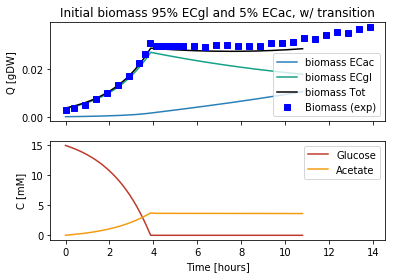

In [35]:
titlab = 'Initial biomass %.0f%% ECgl and %.0f%% ECac' % (pcECgl*100, (1-pcECgl)*100)
plotEnjalbert2015_growth2EC(True, model, expcond, exitname, titlab)
